In [89]:
# !pip install scikit-learn
# !pip install openpyxl
# !pip install imblearn
# !pip install category_encoders
# !pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 41.5 MB/s eta 0:00:00


### Importing required libraries

In [105]:
# Required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso

### Constants and Functions

In [123]:
#####CONSTANTS####
USER='samarthsingh'
FILE_PATH="file:///Users/{}/Downloads/".format(USER)
FILE_NAME="complain_master_dataset.csv"
CONSUMER_CONSENT_PROVIDED_BINARY_ENCONDING={
    # we are categorizing nan as a separate category -1
    'Consent provided': 1, 
    'Consent not provided': 0,
    'Consent withdrawn': 0,  # You can change this to -1 if you wish to handle it separately
    'Other': -1  # Treat 'Other' as a distinct category
}
CONSUMER_DISPUTED_BINARY_ENCODING={
    # we are categorizing nan as a separate category -1
    'Yes': 1,  # Disputed
    'No': 0    # Not disputed
}
COLS_NOT_IN_FEATURES=['Date received','Consumer complaint narrative','Company public response','ZIP code','Tags','Date sent to company','Timely response?','Complaint ID']
###COMMON FUNCTIONS####

    
def fixing_datatype(df):
    """
    :param df: This is the initial dataset we have read
    :return: Returns the dataset by enforcing the schema we have finalized
    """
    df['Company response to consumer'] = df['Company response to consumer'].astype(str)
    df=df.drop(columns=COLS_NOT_IN_FEATURES)
    return df


### Loading Dataset and enforcing schema

In [124]:
# 1. Load dataset from Excel file
  # Replace with your file path
df = pd.read_csv(FILE_PATH+FILE_NAME)
df=fixing_datatype(df)

### Feature Engineering

In [125]:

# 2. Preprocessing

#BOOLEAN COLUMNS

df['Consumer consent provided?'] = df['Consumer consent provided?'].replace(CONSUMER_CONSENT_PROVIDED_BINARY_ENCONDING)
# Handle NaN values by filling them with -1 (for unknown consent status) for Consumer Consent Provided column 
df['Consumer consent provided?']=df['Consumer consent provided?'].fillna(-1)
#  Treat NaN as a separate category (-1) for Consumer Disputed column
df['Consumer disputed?'] = df['Consumer disputed?'].replace(CONSUMER_DISPUTED_BINARY_ENCODING)
df['Consumer disputed?']=df['Consumer disputed?'].fillna(-1)

#CATEGORICAL COLUMN

# Frequency encoding: count the occurrences of each company for company column
df['Company'] = df['Company'].map(df['Company'].value_counts())
# Frequency encoding for product column
df['Product'] = df['Product'].map(df['Product'].value_counts())
# Treat NaN as a separate category as 'Unknown' for Sub-Product column
df['Sub-product']=df['Sub-product'].fillna('Unknown')
# Frequency encoding for Sub-Product column
df['Sub-product'] = df['Sub-product'].map(df['Sub-product'].value_counts())
# Treat NaN as a separate category as 'Unknown' for Issue column
df['Issue']=df['Issue'].fillna('Unknown')
# Frequency encoding for Issue column
df['Issue'] = df['Issue'].map(df['Issue'].value_counts())
# Treat NaN as 'Unknown' for Sub-Issue column
df['Sub-issue']=df['Sub-issue'].fillna('Unknown')
# Frequency encoding for Sub-Issue column
df['Sub-issue'] = df['Sub-issue'].map(df['Sub-issue'].value_counts())

#binary encoding for State column
df['State']=df['State'].fillna('Unknown')
encoder = BinaryEncoder(cols=['State'], return_df=True)
df_encoded = encoder.fit_transform(df['State'])
df = pd.concat([df, df_encoded], axis=1).drop('State', axis=1)

#one hot encoding for Submitted via column
encoder = OneHotEncoder()
# Apply one-hot encoding
encoded_data = encoder.fit_transform(df[['Submitted via']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Submitted via']))
# Concatenate the original DataFrame with the one-hot encoded columns
df = pd.concat([df, encoded_df], axis=1).drop(columns=['Submitted via'])


###TARGET VARIABLE


# Removing the nan from the target variable to prevent problems with undersampling 
df=df[~(df['Company response to consumer']=='nan')]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
df['Company response to consumer'] = label_encoder.fit_transform(df['Company response to consumer'])





/var/folders/n4/myrsyyn96ljdndhtdgy4x2bh0000gp/T/ipykernel_9570/728386498.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Consumer consent provided?'] = df['Consumer consent provided?'].replace(CONSUMER_CONSENT_PROVIDED_BINARY_ENCONDING)
/var/folders/n4/myrsyyn96ljdndhtdgy4x2bh0000gp/T/ipykernel_9570/728386498.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Consumer disputed?'] = df['Consumer disputed?'].replace(CONSUMER_DISPUTED_BINARY_ENCODING)


In [126]:
# df['Company response to consumer'].isnull().sum()
df['Company response to consumer'].value_counts()
# df.dtypes
# ZIP code

Company response to consumer
1    620531
3    284695
6     60562
2     26029
0      2834
5      2816
7      1682
4       847
Name: count, dtype: int64

### Splitting data into training and testing

In [127]:
# 3. Split the data into training and testing sets

X = df.drop(columns=['Company response to consumer']) # Features (all columns except the last)
y = df['Company response to consumer']    # Target (last column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Feature Selection


In [128]:
# # Lasso feature selector
# lasso = Lasso(alpha=0.1)
# lasso.fit(X, y)
# 
# # Feature selection
# selected_features = X.columns[(lasso.coef_ != 0).ravel().tolist()]
# print("Selected Features:", selected_features)
# 
# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

### Undersampling to handle class imbalance

In [129]:
# Check the class distribution before undersampling
print("Class distribution before undersampling:", Counter(y_train))

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling on the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:", Counter(y_train_resampled))


Class distribution before undersampling: Counter({1: 465571, 3: 213040, 6: 45441, 2: 19740, 0: 2147, 5: 2109, 7: 1293, 4: 656})
Class distribution after undersampling: Counter({0: 656, 1: 656, 2: 656, 3: 656, 4: 656, 5: 656, 6: 656, 7: 656})


### Linear Regression Model

In [130]:
# 4. Train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions for Linear Regression
y_pred_linear_train = linear_model.predict(X_train)
y_pred_linear_test = linear_model.predict(X_test)

# Calculate the metrics for Linear Regression
mse_linear_train = mean_squared_error(y_train, y_pred_linear_train)
mse_linear_test = mean_squared_error(y_test, y_pred_linear_test)
r2_linear_train = r2_score(y_train, y_pred_linear_train)
r2_linear_test = r2_score(y_test, y_pred_linear_test)

print("Linear Regression:")
print(f"Train MSE: {mse_linear_train}, Test MSE: {mse_linear_test}")
print(f"Train R²: {r2_linear_train}, Test R²: {r2_linear_test}")

Linear Regression:
Train MSE: 1.5211659638046198, Test MSE: 1.5169355686996366
Train R²: 0.2203075312201992, Test R²: 0.2206345667057097


/var/folders/n4/myrsyyn96ljdndhtdgy4x2bh0000gp/T/ipykernel_9570/1545113913.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


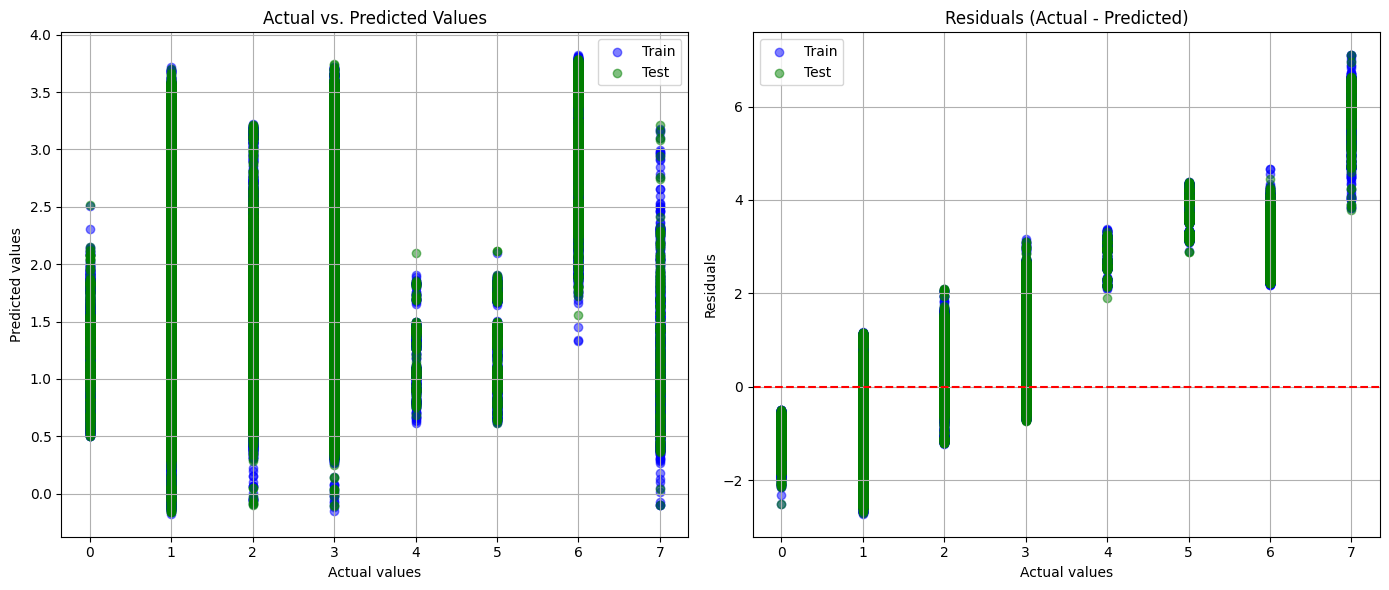

In [100]:
# Plotting Actual vs. Predicted Values for Training and Test sets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_linear_train, alpha=0.5, color='blue', label='Train')
plt.scatter(y_test, y_pred_linear_test, alpha=0.5, color='green', label='Test')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()
plt.grid(True)

# Plotting Residuals for Training and Test sets
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train - y_pred_linear_train, alpha=0.5, color='blue', label='Train')
plt.scatter(y_test, y_test - y_pred_linear_test, alpha=0.5, color='green', label='Test')
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Actual values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Random forest model


Random Forest Regressor:
Train MSE: 0.7926872022926665, Test MSE: 1.0454865893121497
Train R²: 0.5936983495345246, Test R²: 0.46285384462234047


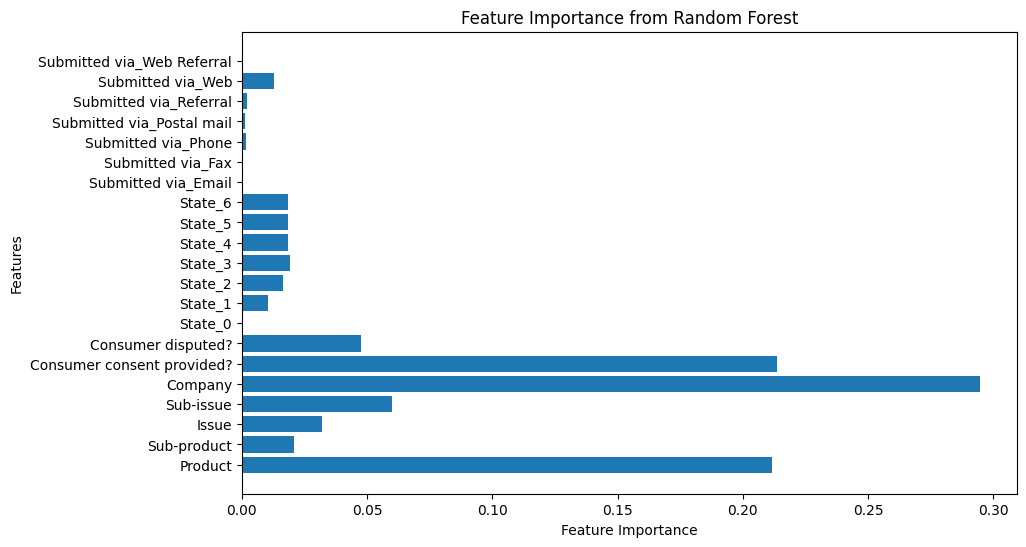

In [131]:
# 5. Train Random Forest Regressor Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions for Random Forest Regressor
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Calculate the metrics for Random Forest Regressor
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
r2_rf_train = r2_score(y_train, y_pred_rf_train)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

print("\nRandom Forest Regressor:")
print(f"Train MSE: {mse_rf_train}, Test MSE: {mse_rf_test}")
print(f"Train R²: {r2_rf_train}, Test R²: {r2_rf_test}")

# 6. Plot feature importance for Random Forest
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.show()